# Import libraries :open_file_folder:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

import warnings
import joblib

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, f1_score
from sklearn.impute import KNNImputer

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Ignore WARNINGS :warning:

In [3]:
warnings.filterwarnings('ignore')

# Read CSV file :scroll: and some edits :pencil:

In [7]:
df = pd.read_csv("../../csv/alpha1_with_id.csv")
df = df.drop(["address", "Unnamed: 0", "uid", "total_floor", 'id', 'total_floors'], axis=1)
# df = df.dropna()
df = df.drop_duplicates()
df.loc[df['type_perec'] == '0', 'type_perec'] = 'Железобетонный'
df.loc[df['fundament'] == '0.0', 'fundament'] = 'Железобетонный'
df.loc[df['fundament'] == '0', 'fundament'] = 'Железобетонный'
df.loc[df['hot_water'] == '0', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == '0.0', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == 'центральное', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == 'Квартирное (квартирный котел)', 'hot_water'] = 'Поквартирный котел'
df.loc[df['hot_water'] == 'Индивидуальный тепловой пункт (ИТП)', 'hot_water'] = 'Закрытая с приготовлением горячей воды на ИТП'
df = df[df['kitchen'].notna()]
df = df[df.year != 0]
df = df[df.year != 0.0]
df = df[df.year != '0'] 
df = df[df.year != '0.0']
df = df[df.kitchen != '0']
df = df[df.kitchen != '0.0']
df = df[df.kitchen != 0]
df = df[df.kitchen != 0.0]

df

,price,floor,rooms,square,city,remont,balcon,view,year,type_perec,hot_water,fundament,kitchen
0,5150000,4,1,30.0,Казань,standard,1,garden,1982,Железобетонный,Центральное,Сплошной,5 м2
1,4400000,4,1,32.0,Казань,standard,1,garden,1962,Деревянный,Центральное,Ленточный,6 м2
2,3550000,10,1,18.6,Казань,standard,1,garden,1989,Железобетонный,Центральное,Ленточный,"5,5 м2"
3,5399999,4,1,27.7,Казань,standard,1,garden,1998,Железобетонный,Центральное,Ленточный,"7,9 м2"
4,6400000,8,1,33.0,Казань,standard,1,garden,2004,Железобетонный,Центральное,Железобетонный,"10,6 м2"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38054,9999990,15,3,79.1,Краснодар,standard,1,garden,2000,Монолитный,Центральное,Железобетонный,10 м2
38055,6300000,16,3,57.0,Краснодар,standard,1,garden,2016,Железобетонный,Центральное,Железобетонный,"7,3 м2"
38056,9350000,2,3,92.0,Краснодар,design,1,garden,2004,Железобетонный,Центральное,Железобетонный,"19,8 м2"
38060,29500000,8,3,112.6,Сочи,well_done,2,garden,2014,Железобетонный,Центральное,Железобетонный,15 м2


In [8]:
df[df['total_floors'].isna()]

KeyError: 'total_floors'

# Fix kitchen values :wrench:

In [9]:
i = 0
for value in df['kitchen']:
    try:
        temp_list = value.split("\xa0")
        value = temp_list[0]
        value = value.replace(",", ".")
    except:
        temp_list = value.split(" ")
        value = temp_list[0]
        value = value.replace(",", ".")
    value = float(value)
    df.kitchen.iloc[i] = value
    i += 1
    print(i, "/", len(df['kitchen']), " " , ceil((i * 100) / len(df['kitchen'])), "%" , end='\r')
    
df.kitchen = pd.to_numeric(df['kitchen'])

# Exploratory Data Analysis (EDA) :gem: :mag:

In [10]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
    print(missing_df, end="\n")
    print("##########################################")
    
    if plot:
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df["ratio"]) 
        plt.xlabel("Features")
        plt.ylabel("Percentage of Missing Values")
        plt.title("Missing Values by Feature")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}%", ha="center", va="bottom", fontsize=8, rotation=90) 
        
        plt.xticks(rotation=90, fontsize=8) 
        plt.yticks(fontsize=8) 
        plt.grid(True)  
        plt.tight_layout()
        plt.show()

    if na_name:
        return na_columns

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
##########################################


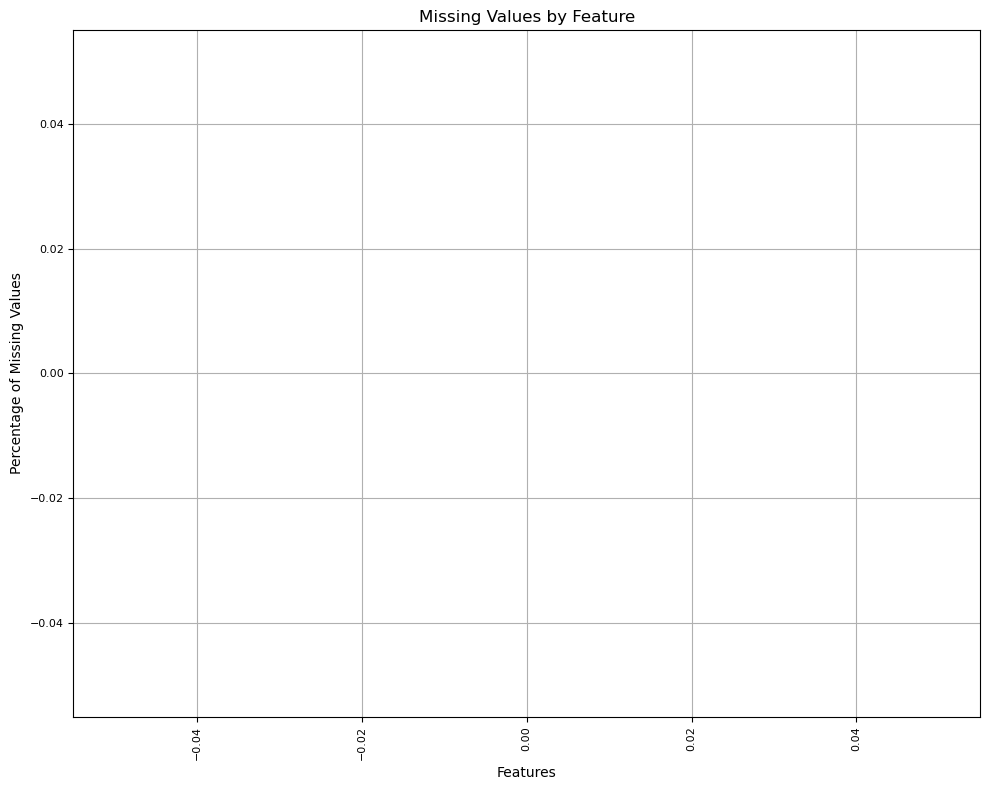

In [11]:
missing_values_table(df, plot=True)

In [12]:
df[df.kitchen == 0]

,price,floor,rooms,square,city,remont,balcon,view,year,type_perec,hot_water,fundament,kitchen


In [ ]:
# def select_imputer(dataframe, target_column, add_column, random_state=42):
#     droplist = [target_column, add_column]
#     X = dataframe.drop(droplist, axis=1)
#     y = dataframe[target_column]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

#     impute_methods = {"mean": SimpleImputer(strategy="mean"),
#                       "median": SimpleImputer(strategy="median"),
#                       "most_frequent": SimpleImputer(strategy="most_frequent"),
#                       "knn": KNNImputer(n_neighbors=5)}

#     results = {}

#     numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
#     categorical_cols = X.select_dtypes(include=["object", "category"]).columns

#     encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#     if dataframe[target_column].dtype not in ["int64", "float64"] or dataframe[target_column].nunique() <= 2:
#         for method_name, imputer in impute_methods.items():
#             X_train_numeric = X_train[numeric_cols]
#             X_test_numeric = X_test[numeric_cols]

#             X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
#             X_test_numeric_imputed = imputer.transform(X_test_numeric)

#             X_train_categorical_imputed = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
#             X_test_categorical_imputed = X_test[categorical_cols].fillna(X_test[categorical_cols].mode().iloc[0])

#             X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed)
#             X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed)

#             X_train_imputed = np.hstack([X_train_numeric_imputed, X_train_categorical_encoded])
#             X_test_imputed = np.hstack([X_test_numeric_imputed, X_test_categorical_encoded])
            
#             model = RandomForestClassifier(random_state=42)
#             model.fit(X_train_imputed, y_train)
            
#             y_pred = model.predict(X_test_imputed)
#             f1 = f1_score(y_test, y_pred)
            
#             results[method_name] = f1

#         for method, f1 in results.items():
#             print(f"Impute method: {method}, F1-Score: {f1:.4f}")

#     else:
#         for method_name, imputer in impute_methods.items():
#             X_train_numeric = X_train[numeric_cols]
#             X_test_numeric = X_test[numeric_cols]

#             X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
#             X_test_numeric_imputed = imputer.transform(X_test_numeric)

#             X_train_categorical_imputed = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
#             X_test_categorical_imputed = X_test[categorical_cols].fillna(X_test[categorical_cols].mode().iloc[0])

#             X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed)
#             X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed)

#             X_train_imputed = np.hstack([X_train_numeric_imputed, X_train_categorical_encoded])
#             X_test_imputed = np.hstack([X_test_numeric_imputed, X_test_categorical_encoded])
            
#             model = RandomForestRegressor(random_state=42)
#             model.fit(X_train_imputed, y_train)
            
#             y_pred = model.predict(X_test_imputed)
#             rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
#             results[method_name] = rmse

#         for method, rmse in results.items():
#             print(f"Impute method: {method}, RMSE: {rmse:.4f}")

In [ ]:
# df_ = df.copy()
# train_df_ = df_[df_["year"].notnull()]
# test_df_ = df_[df_["year"].isnull()]

# select_imputer(train_df_, "year", "id")

In [ ]:
df.info()

In [ ]:
df.isna().sum()

In [ ]:
df = df.dropna()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.duplicated().sum()
df = df.drop_duplicates()

In [ ]:
df

In [ ]:
df.describe()

In [22]:
df

,price,floor,rooms,square,city,remont,balcon,view,year,type_perec,hot_water,fundament,kitchen
0,5150000,4,1,30.0,Казань,standard,1,garden,1982,Железобетонный,Центральное,Сплошной,5.0
1,4400000,4,1,32.0,Казань,standard,1,garden,1962,Деревянный,Центральное,Ленточный,6.0
2,3550000,10,1,18.6,Казань,standard,1,garden,1989,Железобетонный,Центральное,Ленточный,5.5
3,5399999,4,1,27.7,Казань,standard,1,garden,1998,Железобетонный,Центральное,Ленточный,7.9
4,6400000,8,1,33.0,Казань,standard,1,garden,2004,Железобетонный,Центральное,Железобетонный,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38054,9999990,15,3,79.1,Краснодар,standard,1,garden,2000,Монолитный,Центральное,Железобетонный,10.0
38055,6300000,16,3,57.0,Краснодар,standard,1,garden,2016,Железобетонный,Центральное,Железобетонный,7.3
38056,9350000,2,3,92.0,Краснодар,design,1,garden,2004,Железобетонный,Центральное,Железобетонный,19.8
38060,29500000,8,3,112.6,Сочи,well_done,2,garden,2014,Железобетонный,Центральное,Железобетонный,15.0


In [ ]:
# for column in ['type_perec', 'hot_water', 'fundament', 'kitchen']:
#     df[column] = df[column].fillna("0")


In [ ]:
df

In [ ]:
df.nunique()

In [ ]:
df['city'].unique()

# Visualization (graphics)

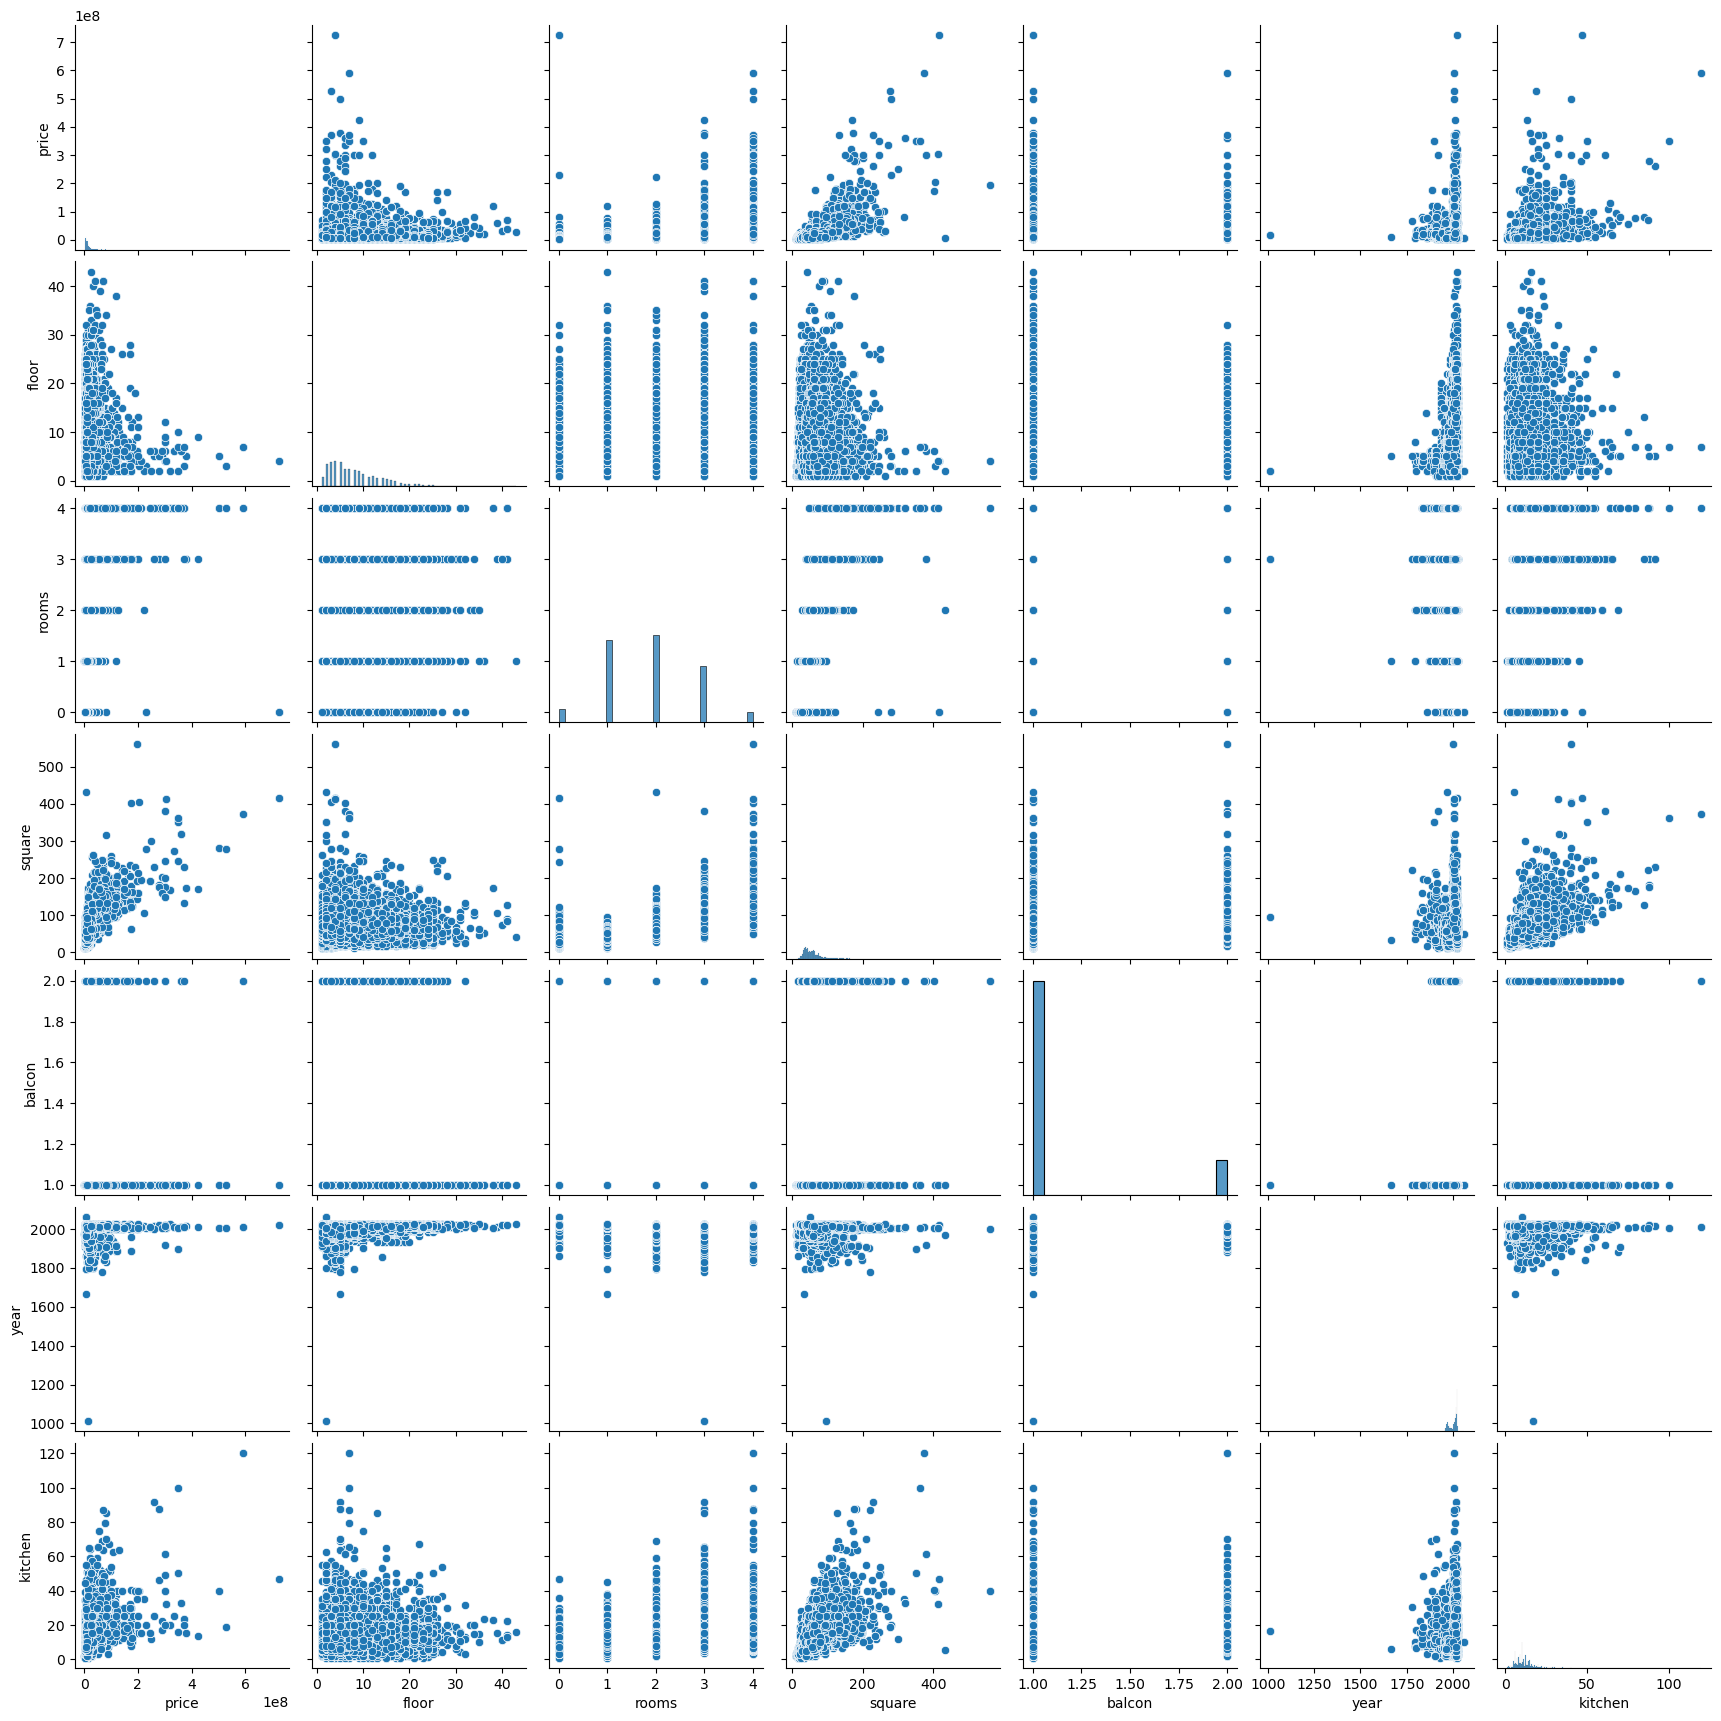

In [13]:
sns.pairplot(df)

In [14]:
count_rooms = df['rooms'].value_counts()
count_rooms

rooms
2    11591
1    10835
3     7450
0     1811
4     1319
Name: count, dtype: int64

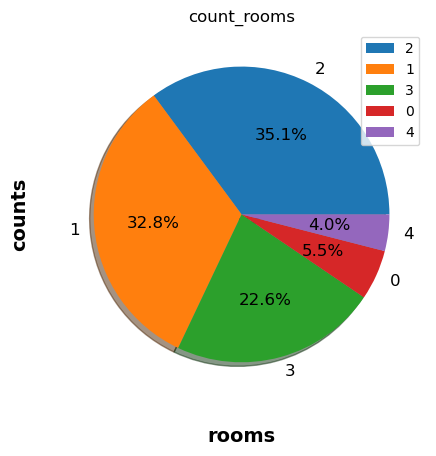

In [15]:
plt.figure()
explode = (0,0.09)
count_rooms.plot(kind = 'pie', fontsize = 12, autopct = '%.1f%%',shadow = True)
plt.title('count_rooms')
plt.xlabel('rooms', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.ylabel('counts', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.legend(labels = count_rooms.index, loc = "best")
plt.show()

In [16]:
count_view = df['view'].value_counts()
count_view

view
garden    18007
street    10535
park       2145
forest     1163
water      1156
Name: count, dtype: int64

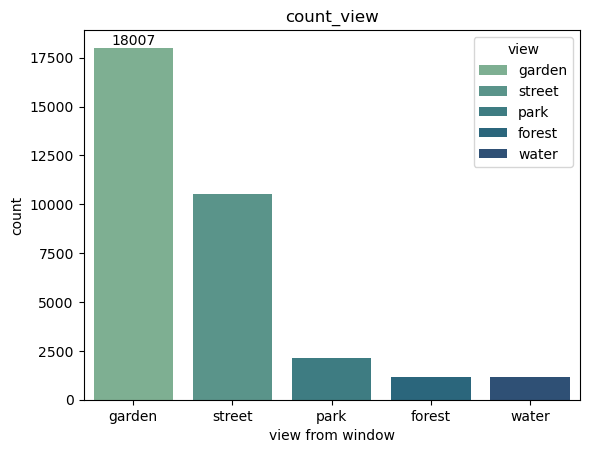

In [17]:
plt.figure()
ax = sns.barplot(x=count_view.index, y=count_view.values, palette='crest', legend=True, hue=count_view.index)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('count_view')
plt.xlabel('view from window')
plt.ylabel('count')
plt.show()

In [ ]:
count_city = df['city'].value_counts()
count_city

In [ ]:
count_fundament = df['fundament'].value_counts()
count_fundament

In [ ]:
plt.figure()
ax = sns.barplot(x = count_fundament.index, y = count_fundament.values, palette='magma', legend=True, hue=count_fundament.index)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('count_fundament')
plt.xlabel('fundament')
plt.ylabel('count')
plt.show()

In [ ]:
count_type_perec = df['type_perec'].value_counts()
count_type_perec

In [ ]:
plt.figure()
ax = sns.barplot(x = count_type_perec.index,y = count_type_perec.values, palette='coolwarm', legend=True, hue=count_type_perec.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_type_perec')
plt.xlabel('type_perec')
plt.ylabel('count')
plt.show()

In [ ]:
count_hot_water = df['hot_water'].value_counts()
count_hot_water

In [ ]:
plt.figure()
explode = (0,0.09)
count_hot_water.plot(kind = 'pie', fontsize = 12, autopct = '%.1f%%',shadow = True)
plt.title('count_hot_water')
plt.xlabel('hot_water', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.ylabel('counts', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.legend(labels = count_hot_water.index, loc = "best")
plt.show()

In [ ]:
count_remont = df['remont'].value_counts()
count_remont

In [ ]:
plt.figure()
ax = sns.barplot(x=count_remont.index,y=count_remont.values, palette='rocket', legend=True, hue=count_remont.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_remont')
plt.xlabel('remont')
plt.ylabel('count')
plt.show()

# Encoding Data :bomb:

In [ ]:
le = LabelEncoder()
columns = ["city", "remont", "view", "type_perec", "hot_water", "fundament", "year"]
for column in columns:
    df[column]=le.fit_transform(df[column])

In [ ]:
plt.figure()
sns.heatmap(df.corr(), cmap='crest', annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.show()

In [ ]:
df.info()

# :star: Features & Target :dart: 

In [18]:
x = df.drop(columns=['price'])
y = df['price']

In [19]:
y

0         5150000
1         4400000
2         3550000
3         5399999
4         6400000
           ...   
38054     9999990
38055     6300000
38056     9350000
38060    29500000
38061    23950000
Name: price, Length: 33006, dtype: int64

In [20]:
y=y.values.reshape(-1,1)
y

array([[ 5150000],
       [ 4400000],
       [ 3550000],
       ...,
       [ 9350000],
       [29500000],
       [23950000]])

# :mag: Scaling and split :scissors:

In [21]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# x = scaler_x.fit_transform(x)
# y = scaler_y.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(x, y, test_size=0.2, shuffle=True, random_state=77)
# joblib.dump(scaler_x, "../../scalers/alpha1_x.bin")
# joblib.dump(scaler_y, "../../scalers/alpha1_y.bin")

# Teach Models :books:

In [28]:
model = CatBoostRegressor(cat_features=[3, 4, 6, 7, 8, 9, 10], iterations=1000000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Results for CatBoost:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score:", r2)
print()

Learning rate set to 0.00025
0:	learn: 20821616.2650035	total: 12.9ms	remaining: 3h 35m 16s
1:	learn: 20818989.5954969	total: 21.9ms	remaining: 3h 2m 23s
2:	learn: 20816396.8880534	total: 32ms	remaining: 2h 57m 52s
3:	learn: 20813729.6558378	total: 41.1ms	remaining: 2h 51m 17s
4:	learn: 20811079.6002715	total: 50.2ms	remaining: 2h 47m 22s
5:	learn: 20808478.7506906	total: 57.9ms	remaining: 2h 40m 44s
6:	learn: 20805863.6573647	total: 66.2ms	remaining: 2h 37m 30s
7:	learn: 20803169.1530003	total: 75.3ms	remaining: 2h 36m 48s
8:	learn: 20800514.3685703	total: 83.6ms	remaining: 2h 34m 48s
9:	learn: 20797897.0325921	total: 92ms	remaining: 2h 33m 24s
10:	learn: 20795329.5680845	total: 99.9ms	remaining: 2h 31m 24s
11:	learn: 20792708.9912437	total: 109ms	remaining: 2h 30m 58s
12:	learn: 20790117.7314740	total: 116ms	remaining: 2h 28m 38s
13:	learn: 20787679.4522236	total: 124ms	remaining: 2h 27m 40s
14:	learn: 20785118.8432499	total: 132ms	remaining: 2h 26m 15s
15:	learn: 20782548.2364337	to

KeyboardInterrupt: 

# Save the best model :floppy_disk:

In [ ]:
# name = Name[accuracy.index(max(accuracy))]
# model = models[Name[accuracy.index(max(accuracy))]]
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
    
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
    
# print(f"Results for {name}:")
# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("R-squared Score:", r2)

model.save_model("../../models/alpha1.bin")


In [ ]:
model.feature_importances_

# Test the best model :triangular_ruler:

# Import test dataset :scroll:

In [ ]:
x_plus = pd.read_csv("../../src/predict_test.csv")

In [ ]:
x_plus

In [ ]:
columns = ["city", "remont", "view", "type_perec", "hot_water", "fundament", "year"]
for column in columns:
    x_plus[column]=le.fit_transform(x_plus[column])
    
x_plus = scaler_x.fit_transform(x_plus)

In [ ]:
y_pred_plus = model.predict(x_plus)
y_pred_plus

In [ ]:
[y_pred_plus]

In [ ]:
y_pred_plus = scaler_y.inverse_transform([y_pred_plus])
ceil(y_pred_plus[0][0])